In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import sklearn as sk

In [3]:
covid = gpd.read_file('datos/covid_periodos.shp', index = True)
covid = covid.set_index(['link','mes']).sort_index(level = 0)

In [4]:
# Separamos los campos geometricos del dataframe
geo = covid.loc[pd.IndexSlice[:,'2021-01'],'geometry']
codiprov = covid.loc[pd.IndexSlice[:,'2021-01'],['codpcia','departamen','provincia']]

from sklearn.preprocessing import StandardScaler

#  dividimos la cantidad de casos y fallecidos por la población
columnas = ['clasificac', 'fallecido']
covid2 = covid.copy()
for i in columnas:
    covid2[i] = covid[i]/covid.personas
covid2 = covid2[columnas]
casos = covid2.iloc[:,0].to_numpy().reshape(525,19) #se selecciona solo una columna del df
scaler = StandardScaler()
scaler.fit(casos)
casos = scaler.transform(casos)

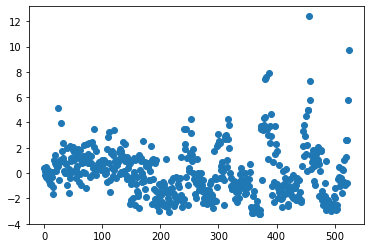

In [5]:
# Análisis de componentes principales 
from sklearn.decomposition import PCA
pca = PCA(1)
casos_pca = pca.fit_transform(casos)
plt.scatter(range(len(casos_pca)),casos_pca[:,0])

In [6]:
pca.score(casos)

-24.672688710980964

In [7]:
def siluetas(X, model):
    return silhouette_score(X, model.labels_)
from sklearn.metrics import silhouette_score 

In [8]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from copy import copy
import time
import sys
class metodo():
    def __init__(self, metodo, param,metric):
        
        # Parameters: 
        # metodo: It is the clustering metodology of scikit learn
        # param: Dictionary of  metodos's parameters 
        self.metodo = metodo
        self.param = param
        self.metric = metric
    def grid(self):
        from sklearn.model_selection import ParameterGrid
        parametros = list(ParameterGrid(self.param))
        return parametros
    
    def modelo(self, diccionario_parametros):
        dic = diccionario_parametros
        kmean = {'n_clusters': 8, 'init': 'k-means++', 'n_init': 10, 'max_iter':300, 'tol': 0.0001}
        aglo = {'n_clusters': 8, 'affinity': 'euclidean', 'memory': None, 'connectivity':None, 'linkage': 'ward'}
        if str(type(self.metodo)) == "<class 'sklearn.cluster._kmeans.KMeans'>":
            for k in kmean.keys():
                try:
                    kmean[k] = dic[k] 
                except KeyError:
                    pass                  
            metod = copy(self.metodo)    
            metod.__init__(n_clusters = kmean['n_clusters'], init = kmean['init'], n_init = kmean['n_init'], tol = kmean['tol'])
            return metod
        
        elif str(type(self.metodo)) == "<class 'sklearn.cluster._agglomerative.AgglomerativeClustering'>":
            for k in aglo.keys():
                try:
                    aglo[k] = dic[k] 
                except KeyError:
                    pass                  
            metod = copy(self.metodo)    
            metod.__init__(n_clusters = aglo['n_clusters'], affinity = aglo['affinity'], memory = aglo['memory'], connectivity = aglo['connectivity'],linkage = aglo['linkage'] )
            return metod
        
        else:
            print('no se reconoce el método')
            
            
    def fit(self, data):
        p = self.grid()
        self.parametros = p
        modelos = []
        for dic in p:
            try:
                model = self.modelo(dic)
                inicio = time.time()
                model.fit(data)
                rdo = self.metric(data, model)
                tiempo = time.time()-inicio
                modelos.append([model,rdo,tiempo, sys.getsizeof(model)])
            except:
                pass
        modelos = pd.DataFrame(modelos, columns = ('modelo','Metrica', 'tiempo','Tamaño'))
        self.modelos = modelos
        self.best_model_ = self.modelos[self.modelos.Metrica == self.modelos.Metrica.max()]
        self.best_time_ = self.modelos[self.modelos.tiempo == self.modelos.tiempo.min()]
    
        

## Eligiendo metodo

Buscamos dentro de una combinación de parámetros aquel que mejor metrica tenga

In [9]:
hiperparam = {
    'n_clusters': np.arange(5,100,5), 'init': ['k-means++', 'random'],
    'n_init' : [10,12,15,20]
}


kmeans = metodo(KMeans(), hiperparam, siluetas)
kmeans.fit(casos)
kmeans.modelos


,modelo,Metrica,tiempo,Tamaño
0,KMeans(n_clusters=5),0.176350,0.042008,56
1,"KMeans(n_clusters=5, n_init=12)",0.211564,0.051011,56
2,"KMeans(n_clusters=5, n_init=15)",0.197643,0.049011,56
3,"KMeans(n_clusters=5, n_init=20)",0.212752,0.060013,56
4,KMeans(n_clusters=10),0.171557,0.051013,56
...,...,...,...,...
147,"KMeans(init='random', n_clusters=90, n_init=20)",0.103376,0.144032,56
148,"KMeans(init='random', n_clusters=95)",0.100753,0.069016,56
149,"KMeans(init='random', n_clusters=95, n_init=12)",0.083590,0.082018,56
150,"KMeans(init='random', n_clusters=95, n_init=15)",0.089976,0.099022,56


In [10]:
kmeans.best_model_

,modelo,Metrica,tiempo,Tamaño
77,"KMeans(init='random', n_clusters=5, n_init=12)",0.214735,0.039009,56


In [11]:
hyperparam_aglo = {'n_clusters':[ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85,
        90, 95],
 'affinity': ['l1', 'l2', 'manhattan', 'cosine'],
 'linkage': ['complete', 'average', 'single']}

aglo = metodo(AgglomerativeClustering(),hyperparam_aglo, siluetas)
aglo.fit(casos)


In [12]:
aglo.best_model_

,modelo,Metrica,tiempo,Tamaño
38,"AgglomerativeClustering(affinity='l1', linkage...",0.687489,0.008002,56
152,"AgglomerativeClustering(affinity='manhattan', ...",0.687489,0.007002,56


<AxesSubplot:>

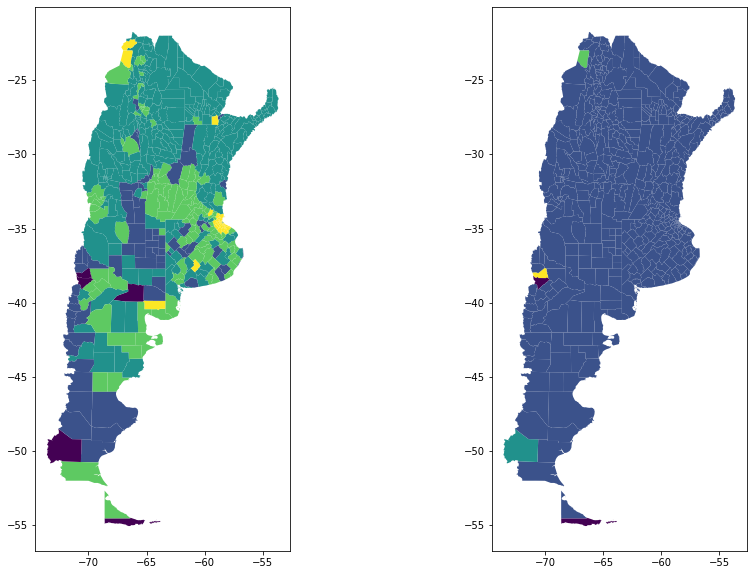

In [13]:
covid_rdos = pd.DataFrame(casos)
covid_rdos['kmeans'] = kmeans.best_model_['modelo'].iloc[0].labels_
covid_rdos['aglo'] = aglo.best_model_['modelo'].iloc[0].labels_
covid_rdos = covid_rdos.set_index(geo.index)
covid_rdos = gpd.GeoDataFrame(covid_rdos, geometry = geo)

fig, ax = plt.subplots(1,2, figsize = (15,10))
covid_rdos.plot('kmeans', ax= ax[0])
covid_rdos.plot('aglo', ax= ax[1])


<AxesSubplot:>

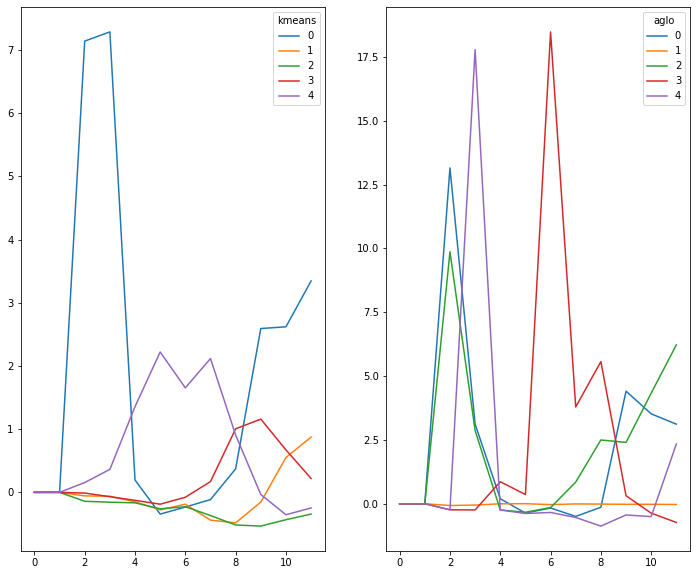

In [14]:
fig, ax = plt.subplots(1,2, figsize = (12,10))
pd.DataFrame(covid_rdos.groupby('kmeans').mean().loc[:,0:11]).T.plot(ax = ax[0])
pd.DataFrame(covid_rdos.groupby('aglo').mean().loc[:,0:11]).T.plot(ax = ax[1])

## Prueba considerando solo el promedio por departamento

<AxesSubplot:>

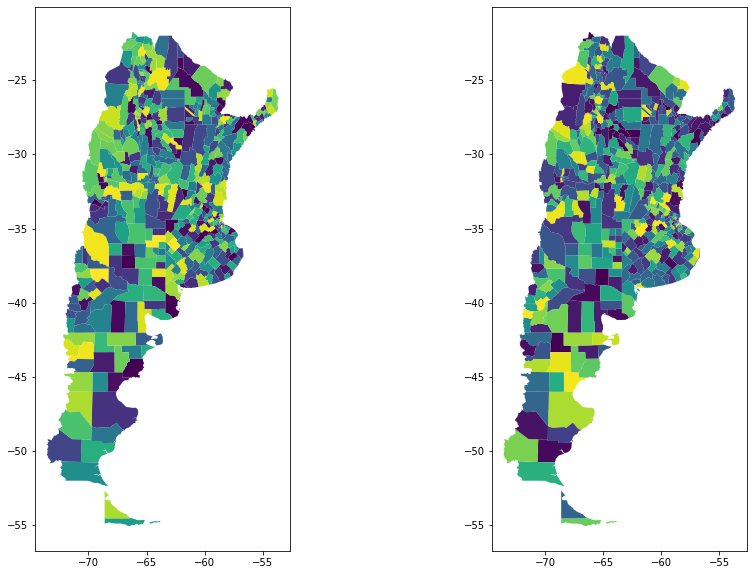

In [15]:
prom_casos = covid2['clasificac'].groupby(level = 0).mean().to_numpy().reshape(525,1)
kmeans.fit(prom_casos)
aglo.fit(prom_casos)

covid_rdos = pd.DataFrame(casos)
covid_rdos['kmeans'] = kmeans.best_model_['modelo'].iloc[0].labels_
covid_rdos['aglo'] = aglo.best_model_['modelo'].iloc[0].labels_
covid_rdos = covid_rdos.set_index(geo.index)
covid_rdos = gpd.GeoDataFrame(covid_rdos, geometry = geo)

fig, ax = plt.subplots(1,2, figsize = (15,10))
covid_rdos.plot('kmeans', ax= ax[0])
covid_rdos.plot('aglo', ax= ax[1])


In [16]:
kmeans.best_model_

,modelo,Metrica,tiempo,Tamaño
38,"KMeans(n_clusters=50, n_init=15)",0.572916,0.152034,56


In [17]:
aglo.best_model_

,modelo,Metrica,tiempo,Tamaño
34,"AgglomerativeClustering(affinity='l1', linkage...",0.57282,0.008002,56
91,"AgglomerativeClustering(affinity='l2', linkage...",0.57282,0.008003,56
148,"AgglomerativeClustering(affinity='manhattan', ...",0.57282,0.008002,56


## Conisderando el coeficiente de localización

In [19]:
import scipy.stats as st
def lq(datos, campo, total):
    ind = datos[campo]/datos[total]
    indg = datos[campo].sum()/datos[total].sum()
    return [ind,indg,ind/indg]

def intervalos(data, campo, total, a = .95):
    indices = lq(data, campo,total) 
    pi = indices[0]
    p = indices[1]
    ni = data[total]
    n = data[total].sum()
    
    var = (pi*(1-pi)/(ni*p**2))+((pi**2)*(1-p)/(n*p**3))+(2*(pi**2)*(1-pi)/(n*p**3))
    sd = np.sqrt(var)
    sd
    np.mean(indices[2])
    sdnorm = st.t.ppf((1+a)/2,2)*sd
    #sdnorm = st.norm.ppf((1+a)/2)*sd
    
    return pd.DataFrame([indices[2]-sdnorm,indices[2]+sdnorm.T,sdnorm,indices[2]]).T 

### Primero consideremos ambos coeficientes con la población

In [ ]:
lq_confirm = scaler.fit_transform(covid[['lq_confirm']].to_numpy().reshape(525,12))
lq_fallec = scaler.fit_transform(covid[['lq_falleci']].to_numpy().reshape(525,12))

kmeans.fit(lq_confirm)
aglo.fit(lq_confirm)

covid_rdos = pd.DataFrame(lq_confirm)
covid_rdos['kmeans'] = kmeans.best_model_['modelo'].iloc[0].labels_
covid_rdos['aglo'] = aglo.best_model_['modelo'].iloc[0].labels_
covid_rdos = covid_rdos.set_index(geo.index)
covid_rdos = gpd.GeoDataFrame(covid_rdos, geometry = geo)

fig, ax = plt.subplots(1,2, figsize = (15,10))
covid_rdos.plot('kmeans', ax= ax[0])
covid_rdos.plot('aglo', ax= ax[1])

In [65]:
pd.concat([kmeans.best_model_,aglo.best_model_])

,modelo,Metrica,tiempo,Tamaño
3,"KMeans(n_clusters=5, n_init=20)",0.239821,0.162082,56
19,"AgglomerativeClustering(affinity='l1', linkage...",0.593814,0.016955,56
38,"AgglomerativeClustering(affinity='l1', linkage...",0.593814,0.008975,56
133,"AgglomerativeClustering(affinity='manhattan', ...",0.593814,0.011967,56
152,"AgglomerativeClustering(affinity='manhattan', ...",0.593814,0.007976,56


<AxesSubplot:>

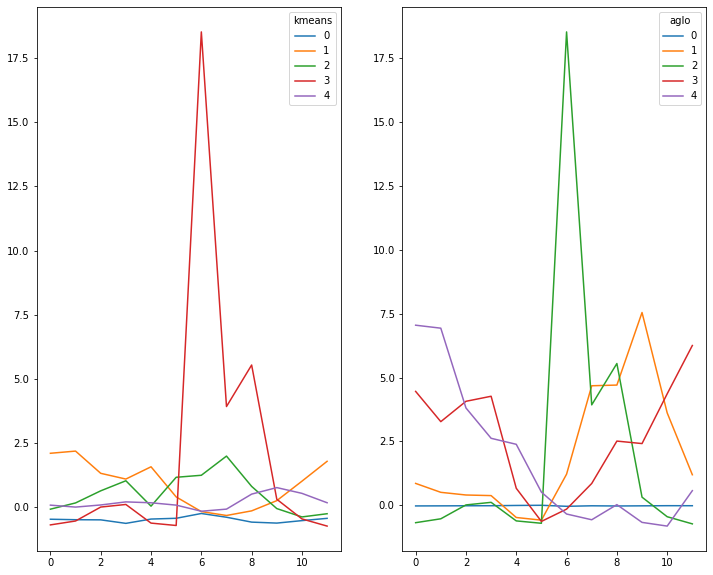

In [67]:
fig, ax = plt.subplots(1,2, figsize = (12,10))
pd.DataFrame(covid_rdos.groupby('kmeans').mean().loc[:,0:11]).T.plot(ax = ax[0])
pd.DataFrame(covid_rdos.groupby('aglo').mean().loc[:,0:11]).T.plot(ax = ax[1])

In [68]:
covid_rdos.query("aglo == 3")

,,0,1,2,3,4,5,6,7,8,9,10,11,kmeans,aglo,geometry
link,mes,,,,,,,,,,,,,,,
78028,1,4.456311,3.27363,4.068994,4.266705,0.667445,-0.62786,-0.147074,0.855612,2.513576,2.416368,4.361768,6.251378,1,3,"POLYGON ((-72.58866 -48.49082, -72.04663 -48.8..."


In [69]:
covid.loc[50014]

,clasificac,fallecido,codpcia,departamen,provincia,mujeres,varones,personas,hogares,viv_part,viv_part_h,lq_confirm,lq_falleci,geometry
mes,,,,,,,,,,,,,,
1,218.0,6.0,50,General Alvear,Mendoza,23879,22550,46429,14748,16795,14113,0.655028,0.891997,"POLYGON ((-66.69534 -34.66511, -66.69197 -34.6..."
2,119.0,5.0,50,General Alvear,Mendoza,23879,22550,46429,14748,16795,14113,0.607586,1.109461,"POLYGON ((-66.69534 -34.66511, -66.69197 -34.6..."
3,120.0,9.0,50,General Alvear,Mendoza,23879,22550,46429,14748,16795,14113,0.429083,1.420872,"POLYGON ((-66.69534 -34.66511, -66.69197 -34.6..."
4,1016.0,49.0,50,General Alvear,Mendoza,23879,22550,46429,14748,16795,14113,1.968881,4.256395,"POLYGON ((-66.69534 -34.66511, -66.69197 -34.6..."
5,516.0,18.0,50,General Alvear,Mendoza,23879,22550,46429,14748,16795,14113,0.839027,2.118919,"POLYGON ((-66.69534 -34.66511, -66.69197 -34.6..."
6,23.0,3.0,50,General Alvear,Mendoza,23879,22550,46429,14748,16795,14113,0.174969,0.933433,"POLYGON ((-66.69534 -34.66511, -66.69197 -34.6..."
7,2.0,4.0,50,General Alvear,Mendoza,23879,22550,46429,14748,16795,14113,0.014207,0.607842,"POLYGON ((-66.69534 -34.66511, -66.69197 -34.6..."
8,12.0,3.0,50,General Alvear,Mendoza,23879,22550,46429,14748,16795,14113,0.047562,0.309621,"POLYGON ((-66.69534 -34.66511, -66.69197 -34.6..."
9,135.0,2.0,50,General Alvear,Mendoza,23879,22550,46429,14748,16795,14113,0.368326,0.160948,"POLYGON ((-66.69534 -34.66511, -66.69197 -34.6..."


## Probamos con fallecidos

<AxesSubplot:>

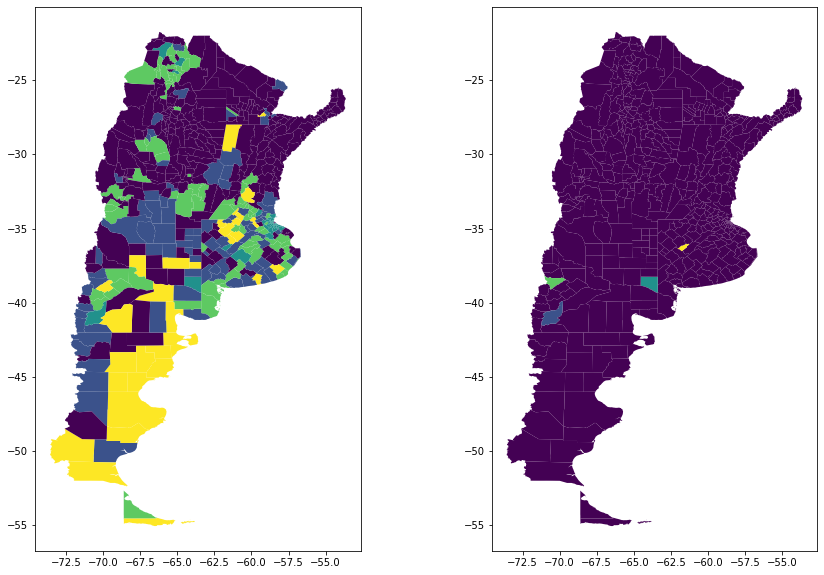

In [79]:
kmeans.fit(lq_fallec)
aglo.fit(lq_fallec)

covid_rdos = pd.DataFrame(lq_fallec)
covid_rdos['kmeans'] = kmeans.best_model_['modelo'].iloc[0].labels_
covid_rdos['aglo'] = aglo.best_model_['modelo'].iloc[0].labels_
covid_rdos = covid_rdos.set_index(geo.index)
covid_rdos = gpd.GeoDataFrame(covid_rdos, geometry = geo)

fig, ax = plt.subplots(1,2, figsize = (15,10))
covid_rdos.plot('kmeans', ax= ax[0])
covid_rdos.plot('aglo', ax= ax[1])

In [71]:
pd.concat([kmeans.best_model_,aglo.best_model_])

,modelo,Metrica,tiempo,Tamaño
76,"KMeans(init='random', n_clusters=5)",0.244155,0.086034,56
38,"AgglomerativeClustering(affinity='l1', linkage...",0.551189,0.008975,56
152,"AgglomerativeClustering(affinity='manhattan', ...",0.551189,0.012272,56


<AxesSubplot:>

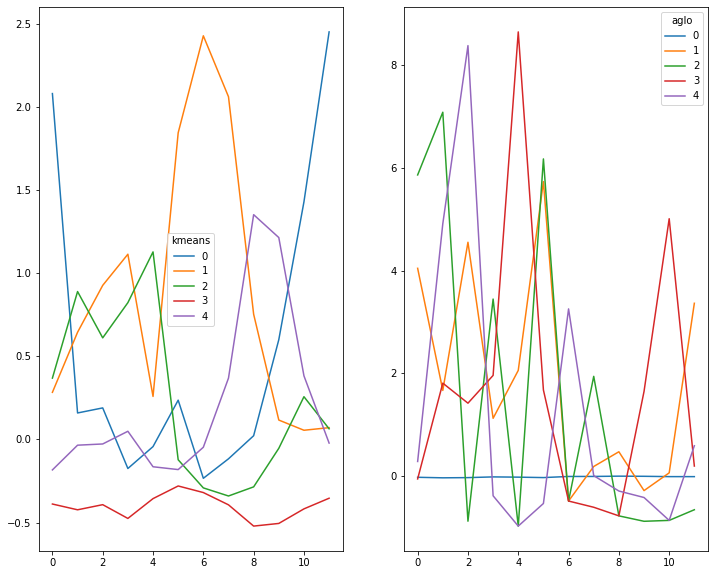

In [72]:
fig, ax = plt.subplots(1,2, figsize = (12,10))
pd.DataFrame(covid_rdos.groupby('kmeans').mean().loc[:,0:11]).T.plot(ax = ax[0])
pd.DataFrame(covid_rdos.groupby('aglo').mean().loc[:,0:11]).T.plot(ax = ax[1])

In [73]:
covid_rdos.query("aglo == 3")

,,0,1,2,3,4,5,6,7,8,9,10,11,kmeans,aglo,geometry
link,mes,,,,,,,,,,,,,,,
58105,1,-0.051383,1.811795,1.422068,1.962237,8.643289,1.678529,-0.481478,-0.602308,-0.76978,1.650188,5.009645,0.199012,2,3,"POLYGON ((-70.61339 -38.27694, -70.61322 -38.2..."


In [74]:
silhouette_score(lq_fallec,codiprov),silhouette_score(lq_confirm,codiprov)


ValueError: y should be a 1d array, got an array of shape (525, 3) instead.

<AxesSubplot:>

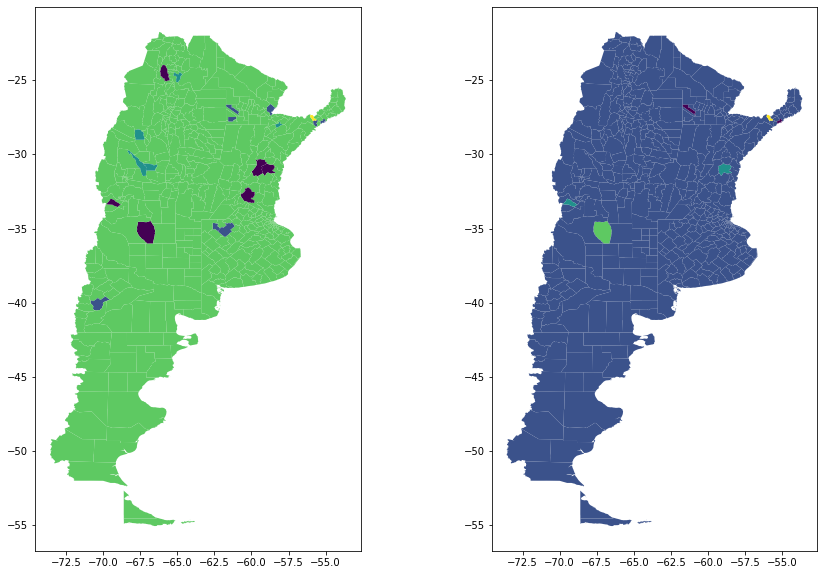

In [80]:

lq_fall_conf = lq(covid,'fallecido','clasificac')[2].fillna(0).replace(np.inf, 0)
lq_fall_conf = lq_fall_conf.to_numpy().reshape(525,12)

kmeans.fit(lq_fall_conf)
aglo.fit(lq_fall_conf)


covid_rdos = pd.DataFrame(lq_fall_conf)
covid_rdos['kmeans'] = kmeans.best_model_['modelo'].iloc[0].labels_
covid_rdos['aglo'] = aglo.best_model_['modelo'].iloc[0].labels_
covid_rdos = covid_rdos.set_index(geo.index)
covid_rdos = gpd.GeoDataFrame(covid_rdos, geometry = geo)

fig, ax = plt.subplots(1,2, figsize = (15,10))
covid_rdos.plot('kmeans', ax= ax[0])
covid_rdos.plot('aglo', ax= ax[1])

# Considerando variables acumuladas

In [81]:
covid_acum = covid[columnas].groupby(covid.index.get_level_values(0)).cumsum()
# buscamos el mes en que todos los dptos tienen al menos 1 contagio
mes = 1
valor = True
while valor == True:
    valor = np.any(covid_acum.loc[pd.IndexSlice[:,mes],'clasificac'] == 0)
    mes +=1
print("El mes desde el cuál todos los dptos tienen al menos 1 contagiado es: "+str(mes))


El mes desde el cuál todos los dptos tienen al menos 1 contagiado es: 4


In [117]:
from sklearn import preprocessing
normalizerl1 = preprocessing.Normalizer(norm = 'l1')

covid2 = covid_acum.loc[pd.IndexSlice[:,mes:],:]
lq_fall_conf = lq(covid2,'fallecido','clasificac')[2]
lq_fall_conf = lq_fall_conf.to_numpy().reshape(525,9)
#lq_fall_conf = scaler.fit_transform(lq_fall_conf) # Transformación standar
lq_fall_conf = normalizerl1.fit_transform(lq_fall_conf) # transformación normalizando con norma l1
kmeans.fit(lq_fall_conf) # se ajusta de acuerdo a los mismos parámetros anteriores
aglo.fit(lq_fall_conf)

<AxesSubplot:>

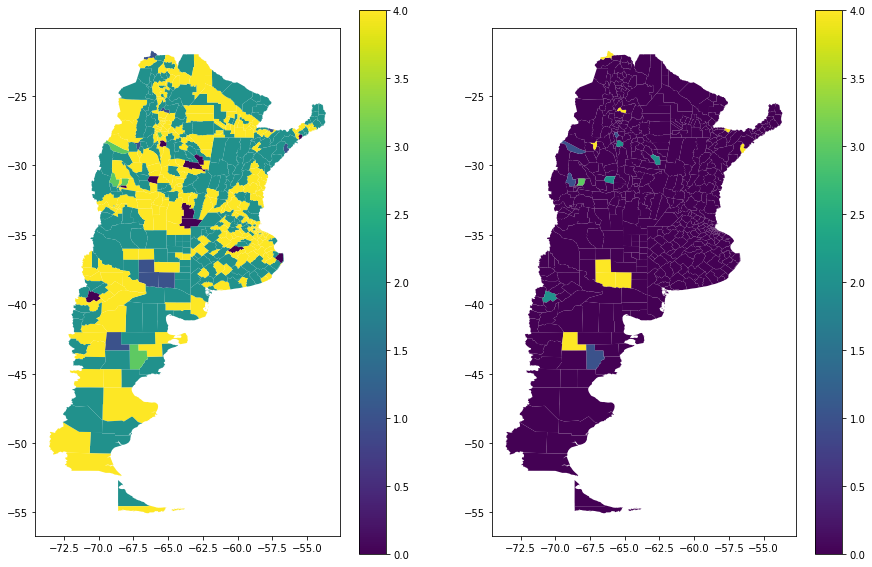

In [118]:
covid_rdos = pd.DataFrame(lq_fall_conf)
covid_rdos['kmeans'] = kmeans.best_model_['modelo'].iloc[0].labels_
covid_rdos['aglo'] = aglo.best_model_['modelo'].iloc[0].labels_
#covid_rdos['aglo'] = aglo.modelos.loc[25]['modelo'].labels_
covid_rdos = covid_rdos.set_index(geo.index)
covid_rdos = gpd.GeoDataFrame(covid_rdos, geometry = geo)

fig, ax = plt.subplots(1,2, figsize = (15,10))
covid_rdos.plot('kmeans', ax= ax[0], legend = True)
covid_rdos.plot('aglo', ax= ax[1], legend = True)

In [119]:
pd.concat([kmeans.best_model_,aglo.best_model_])

,modelo,Metrica,tiempo,Tamaño
76,"KMeans(init='random', n_clusters=5)",0.270882,0.101728,56
77,"KMeans(init='random', n_clusters=5, n_init=12)",0.270882,0.109706,56
78,"KMeans(init='random', n_clusters=5, n_init=15)",0.270882,0.166554,56
79,"KMeans(init='random', n_clusters=5, n_init=20)",0.270882,0.220412,56
76,"AgglomerativeClustering(affinity='l2', linkage...",0.769249,0.011968,56


<AxesSubplot:>

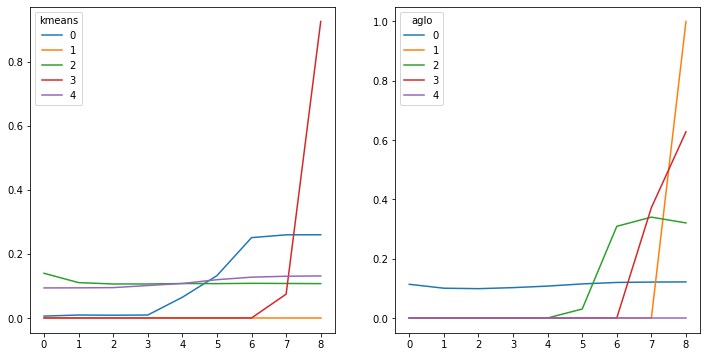

In [120]:
fig, ax = plt.subplots(1,2, figsize = (12,6))
pd.DataFrame(covid_rdos.groupby('kmeans').mean().loc[:,0:8]).T.plot(ax = ax[0])
pd.DataFrame(covid_rdos.groupby('aglo').mean().loc[:,0:8]).T.plot(ax = ax[1])

<AxesSubplot:>

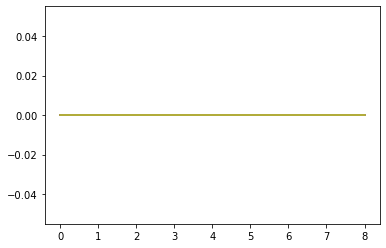

In [128]:
pd.DataFrame(covid_rdos.query('aglo == 4').loc[:,0:8]).T.plot(legend = False)

In [86]:
covid_rdos.query('aglo == 2')

,,0,1,2,3,4,5,6,7,8,kmeans,aglo,geometry
link,mes,,,,,,,,,,,,
86112,1,-1.254882,-1.493309,-1.542614,-1.550856,-1.573501,-1.627347,4.902387,4.518292,3.726693,0,2,"POLYGON ((-63.15261 -29.30680, -63.11922 -29.2..."


In [87]:
covid_rdos.query('kmeans == 3')

,,0,1,2,3,4,5,6,7,8,kmeans,aglo,geometry
link,mes,,,,,,,,,,,,
2001,1,-0.168103,-0.239701,-0.157251,-0.056831,-0.148106,-0.157615,-0.185371,-0.196311,-0.180504,3,0,"POLYGON ((-58.37501 -34.57959, -58.36690 -34.5..."
2002,1,-0.340835,-0.164227,-0.086018,-0.066135,-0.013953,-0.068361,-0.146391,-0.108142,-0.145796,3,0,"POLYGON ((-58.40084 -34.57126, -58.40005 -34.5..."
2003,1,-0.292003,-0.278430,-0.062151,-0.034681,-0.056286,-0.108018,-0.151456,-0.127139,-0.132319,3,0,"POLYGON ((-58.39365 -34.60154, -58.39348 -34.6..."
2004,1,-0.419183,-0.391053,-0.374868,-0.311140,-0.303287,-0.301957,-0.347815,-0.349244,-0.368973,3,0,"POLYGON ((-58.35695 -34.61980, -58.35672 -34.6..."
2005,1,-0.481775,-0.500670,-0.383367,-0.187427,-0.129299,-0.102717,-0.197000,-0.189438,-0.198256,3,0,"POLYGON ((-58.41672 -34.59976, -58.41638 -34.5..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
86154,1,-1.254882,-0.068190,-0.140464,-0.193640,-0.262592,-0.342223,-0.457211,-0.558487,-0.733451,3,0,"POLYGON ((-62.11966 -30.40271, -62.13319 -30.3..."
86161,1,0.146426,0.202834,0.296271,0.204435,-0.090453,-0.353596,-0.168835,-0.262619,-0.195906,3,0,"POLYGON ((-64.20882 -27.81282, -64.15764 -27.7..."
86168,1,0.183302,-0.132968,-0.152873,-0.205650,-0.274193,-0.407568,-0.517756,-0.568062,-0.606191,3,0,"POLYGON ((-63.55704 -28.61659, -63.52044 -28.5..."


In [88]:
codiprov.loc[22049]

,codpcia,departamen,provincia
mes,,,
1,22,General Belgrano,Chaco


In [89]:
covid2 = covid_acum.loc[pd.IndexSlice[:,mes:],:]
lq_fall_conf = lq(covid2,'fallecido','clasificac')[2]
lq_fall_conf = (lq_fall_conf.to_numpy().reshape(525,9))**2
kmeans.fit(lq_fall_conf) # se ajusta de acuerdo a los mismos parámetros anteriores
aglo.fit(lq_fall_conf)

In [39]:
pd.concat([kmeans.best_model_,aglo.best_model_])

,modelo,Metrica,tiempo,Tamaño
1,"KMeans(n_clusters=5, n_init=12)",0.553114,0.092157,56
2,"KMeans(n_clusters=5, n_init=15)",0.553114,0.098017,56
3,"KMeans(n_clusters=5, n_init=20)",0.553114,0.133132,56
19,"AgglomerativeClustering(affinity='l1', linkage...",0.791680,0.013964,56
133,"AgglomerativeClustering(affinity='manhattan', ...",0.791680,0.010340,56


<AxesSubplot:>

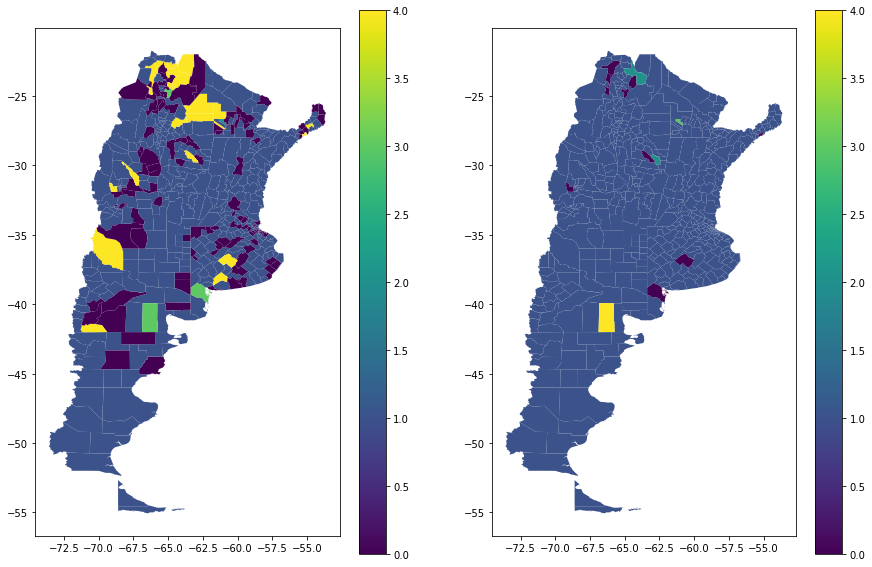

In [40]:
covid_rdos = pd.DataFrame(np.sqrt(lq_fall_conf))
covid_rdos['kmeans'] = kmeans.best_model_['modelo'].iloc[0].labels_
covid_rdos['aglo'] = aglo.best_model_['modelo'].iloc[0].labels_
covid_rdos = covid_rdos.set_index(geo.index)
covid_rdos = gpd.GeoDataFrame(covid_rdos, geometry = geo)

fig, ax = plt.subplots(1,2, figsize = (15,10))
covid_rdos.plot('kmeans', ax= ax[0], legend = True)
covid_rdos.plot('aglo', ax= ax[1], legend = True)

<AxesSubplot:>

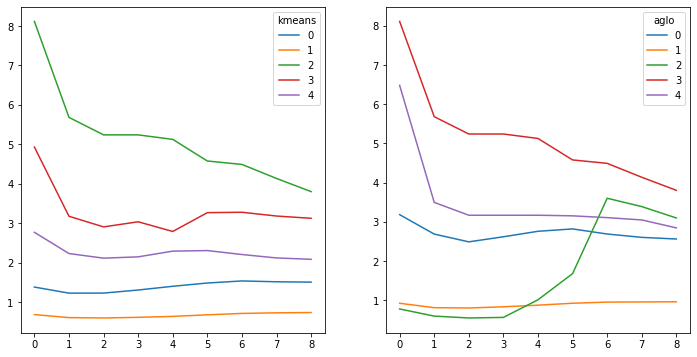

In [41]:
fig, ax = plt.subplots(1,2, figsize = (12,6)) 
pd.DataFrame(covid_rdos.groupby('kmeans').mean().loc[:,0:8]).T.plot(ax = ax[0])
pd.DataFrame(covid_rdos.groupby('aglo').mean().loc[:,0:8]).T.plot(ax = ax[1])

In [42]:
covid_rdos.query("aglo == 4")

,,0,1,2,3,4,5,6,7,8,kmeans,aglo,geometry
link,mes,,,,,,,,,,,,
62084,1,6.483179,3.496363,3.169117,3.169117,3.169117,3.153582,3.107878,3.048961,2.846597,3,4,"POLYGON ((-66.83132 -39.91970, -66.83127 -39.9..."


# Tensor flow

In [43]:
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

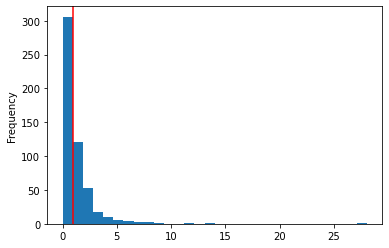

In [44]:
x = pd.DataFrame(lq_fall_conf, index = codiprov.index.get_level_values(0))
x.mean(axis = 1).plot(kind= 'hist', bins = 30)
plt.axvline(x = 1, color = 'red')

In [45]:
x.loc[86112].mean()

4.1512021645015675

In [46]:
x = x.to_numpy().reshape(525,1,9)

In [57]:
y = pd.DataFrame(kmeans.best_model_['modelo'].iloc[0].labels_, index = codiprov.index.get_level_values(0))
y = y.to_numpy().reshape(525,1)

In [58]:
model = tf.keras.Sequential()
model.add(layers.Flatten(input_shape=[1, 9]))
#model.add(layers.Dense(100, activation = 'relu'))
model.add(layers.Dense(5, activation = 'softmax' ))

In [59]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 9)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 50        
Total params: 50
Trainable params: 50
Non-trainable params: 0
_________________________________________________________________


In [60]:
model.compile(loss="sparse_categorical_crossentropy",
optimizer="sgd",
metrics=["accuracy"])

In [61]:
history = model.fit(x, y, epochs=30)

Epoch 1/30
17/17 [==============================] - 0s 1ms/step - loss: 2.1283 - accuracy: 0.1010
Epoch 2/30
17/17 [==============================] - 0s 647us/step - loss: 1.6098 - accuracy: 0.4571
Epoch 3/30
17/17 [==============================] - 0s 1ms/step - loss: 1.4644 - accuracy: 0.6571
Epoch 4/30
17/17 [==============================] - 0s 645us/step - loss: 1.4088 - accuracy: 0.7371
Epoch 5/30
17/17 [==============================] - 0s 997us/step - loss: 1.3586 - accuracy: 0.7695
Epoch 6/30
17/17 [==============================] - 0s 704us/step - loss: 1.3218 - accuracy: 0.8019
Epoch 7/30
17/17 [==============================] - 0s 939us/step - loss: 1.2866 - accuracy: 0.8133
Epoch 8/30
17/17 [==============================] - 0s 645us/step - loss: 1.2552 - accuracy: 0.8267
Epoch 9/30
17/17 [==============================] - 0s 763us/step - loss: 1.2246 - accuracy: 0.8552
Epoch 10/30
17/17 [==============================] - 0s 587us/step - loss: 1.1922 - accuracy: 0.8514
Epo

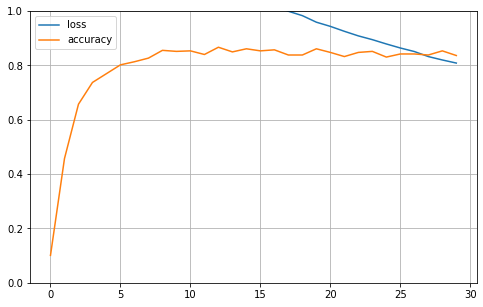

In [62]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [63]:
model.evaluate(x,y)

17/17 [==============================] - 0s 880us/step - loss: 0.7922 - accuracy: 0.8438


[0.7922428250312805, 0.8438095450401306]

In [64]:
model.predict_classes(x)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 1, 4, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 4, 1, 1, 0, 1,